In [24]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, set_link_color_palette
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from scipy.spatial.distance import squareform
import numpy as np

# sys.path.insert(1, '../')
# from dict_types import *

sys.path.insert(1,'../CompareNormalisation')
from Functions import spaced_colors_from_cmap, compute_metric_sensitivity_by_resolution, plot_histograms, type_color_map_2, type_color_map_1
import MetricMapping

def clean_and_map(col):
    for metric in sorted(name_mapping.keys(), key=len, reverse=True):
        if col.startswith(metric):
            return name_mapping[metric]
    return col  # leave unchanged if no match

## Read dataframe of results for all gauges

In [100]:
all_events_5mins = pd.read_csv("../Data/MinMaxScaled_5m.csv")

column_names = all_events_5mins.columns.str.replace('_log', '')
column_names = column_names.str.replace('_yj', '')
all_events_5mins.columns = column_names

### Remove columns we're not interested in (rn)

In [105]:
cols_to_delete = ['duration',  'total_precip', 'mean intensity']
for col in cols_to_delete:
    del all_events_5mins[col]

In [102]:
column_names = all_events_5mins.columns
column_names = column_names.str.replace('_wi', '')
all_events_5mins.columns = column_names

### Rename columns

In [106]:
type_mapping = MetricMapping.type_mapping
name_mapping = MetricMapping.name_mapping

In [107]:
all_events_5mins = all_events_5mins.rename(columns=lambda col: clean_and_map(col))

## Cluster analysis

In [8]:
# all_events_5mins_copy = all_events_5mins.copy()
# del all_events_5mins_copy['Mean intensity']
# del all_events_5mins_copy['Max intensity']
all_events_5mins.columns

Index(['Peak position ratio', 'TCI', 'Asymm. dependence', 'Event Loading',
       '$Skew_{p}$', 'Gini', 'Lorenz Asymm.', 'Event-dry ratio',
       '(T) skewness', 'CoG', 'CoG (interp.)', 'm3', 'm4', 'm5', 'Frac Q1',
       'Frac Q2', 'Frac Q3', '% time HIZ', '% time LIZ', '% rain HIZ',
       '3rd with most', '4th with most', '5th with most', '3rd (ppr)',
       '3rd with peak', '4th with peak', '5th with peak', '3rd ($D_{50}$)',
       '3rd (CoG)', 'T50', 'T75', '$D_{50}$', 'norm_time_std', 'total_precip',
       'I30', 'Mean intensity', 'Max intensity', '(C) Std', 'Cv',
       '(C) skewness', '(C) kurtosis', 'Time to peak', 'duration',
       'Relative amplitude', 'Relative amplitude', 'Peak-mean ratio',
       'Peak-mean ratio', 'PCI', '$NMRSE_{p}$', 'Intermittency',
       '(T) kurtosis', '(T) std', 'm1', 'm2', 'Frac Q4', 'Mean Intensity HIZ',
       'T25', 'BSC_Index', 'event_num'],
      dtype='object')

In [109]:
# var1='Mean intensity'
# var2 = 'duration'
# plt.scatter(all_events_5mins[var1], all_events_5mins[var2])
# plt.xlabel(var1, fontsize=20)
# plt.ylabel(var2, fontsize=20);

In [110]:
data_for_clustering = all_events_5mins.T  
names = data_for_clustering.index

In [111]:
resolutions = ['10m', '30m', '60m']
resolution_colors = {'10m': '#1f77b4', '30m': '#ff7f0e', '60m': '#2ca02c'}

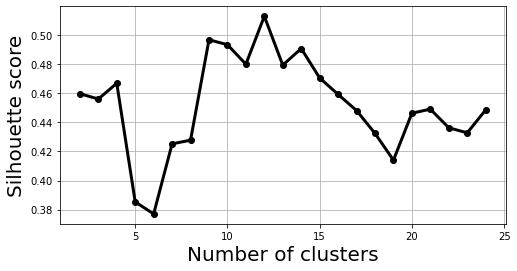

In [112]:
# Step 1: Compute correlation distance matrix (1 - Pearson correlation)
# corr = data_for_clustering.T.corr().abs()
corr = data_for_clustering.T.corr(method='spearman').abs()
dist_matrix = 1 - corr

# Step 2: Convert distance matrix to condensed form (for linkage)

condensed_dist = squareform(dist_matrix, checks=False)

# Step 3: Do clustering
Z = linkage(condensed_dist, method='average')  # Use 'average' for correlation distances
range_n_clusters = range(2, 25)
silhouette_scores = []

# Step 4: Evaluate silhouette scores manually
for n_clusters in range_n_clusters:
    labels = fcluster(Z, n_clusters, criterion='maxclust')

    # Use precomputed distance matrix for silhouette score
    score = silhouette_score(dist_matrix, labels, metric='precomputed')
    silhouette_scores.append(score)
# Plot the silhouette scores
fig, ax=plt.subplots(figsize=(8, 4))
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='black')
plt.xlabel("Number of clusters", fontsize=20)
plt.ylabel("Silhouette score", fontsize=20)
plt.grid(True)
fig.savefig("../Figures/silhoutte_scores.png", dpi=300, facecolor='white')
plt.show()

In [113]:
all_metric_names = names

# --- Assign types ---
metric_type_df = (
    pd.DataFrame({'metric': all_metric_names})
    .assign(type_2=lambda df: df['metric'].map(type_mapping)))

metric_type_df.fillna('Categorical', inplace=True)

In [116]:
label_list = [label.get_text() for label in ax.get_yticklabels()]
label_list.reverse()

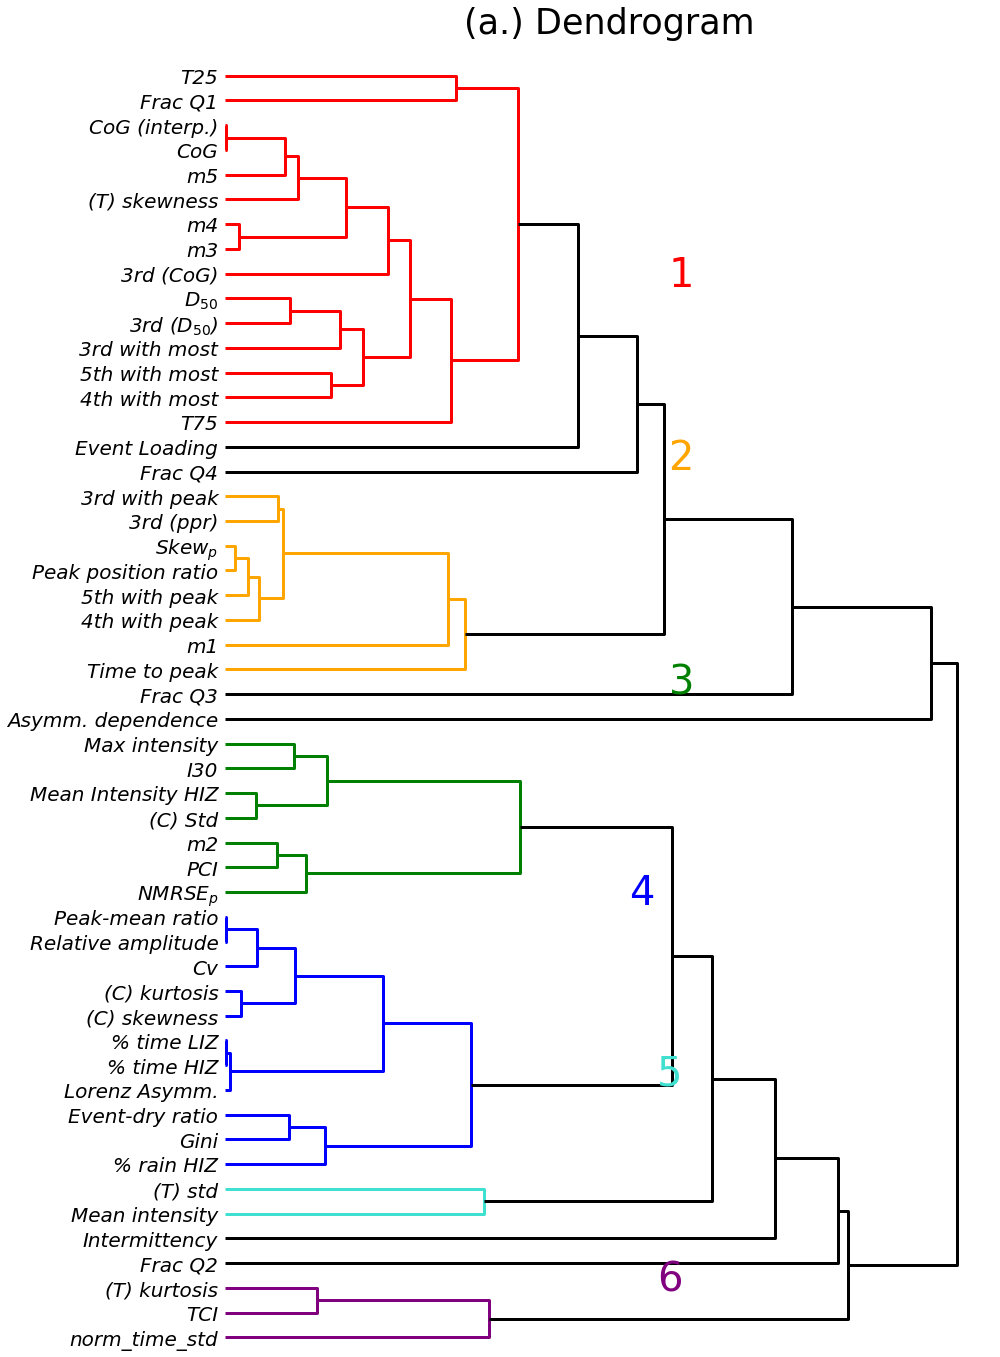

In [117]:
matplotlib.rcParams['lines.linewidth'] =3
type_lookup = dict(zip(all_metric_names, metric_type_df['type_2']))

set_link_color_palette(['purple', 'turquoise', 'blue', 'green', 'orange','red'])

# 1 - absolute correlation → distance
corr = data_for_clustering.T.corr().abs()
dist = 1 - corr
dist_condensed = squareform(dist.values)  # convert to condensed form for linkage

Z = linkage(dist_condensed, method='average')  # or 'complete', 'single', etc.
n_clusters = 12
threshold = Z[-(n_clusters - 1), 2] 
fig, ax = plt.subplots(figsize=(14, 20))
ddata = dendrogram(
    Z,
    labels=data_for_clustering.index,
    leaf_rotation=0,
    leaf_font_size=20,
    orientation='right',
    ax=ax,
    color_threshold=threshold,  # Use this instead of 0
    above_threshold_color='black')


# for cut in [0.42]:
#     plt.axvline(cut, color='red', linewidth=2, ymin=0.71, ymax=0.995, linestyle='dashed',zorder=5)
# for cut in [360, 508]:
#     plt.axhline(cut, color='red', linewidth=2, zorder=5, xmin=0, linestyle='dashed',xmax=0.42)
ax.text(0.58, 430, '1', horizontalalignment='center', color='red', size =40)

# for cut in [0.42]:
#     plt.axvline(cut, color='red', linewidth=2, linestyle='dashed',ymin=0.51, ymax=0.665, zorder=5)
# for cut in [259, 340]:
#     plt.axhline(cut, color='red', linewidth=2, linestyle='dashed',zorder=5, xmin=0, xmax=0.42)    
ax.text(0.58, 356, '2', horizontalalignment='center', color='orange', size =40)

# for cut in [0.42]:
#     plt.axvline(cut, color='red', linewidth=2, linestyle='dashed',ymin=0.335, ymax=0.47, zorder=5)
# for cut in [172, 240]:
#     plt.axhline(cut, color='red', linewidth=2, linestyle='dashed',zorder=5, xmin=0, xmax=0.42)    
ax.text(0.58, 265, '3', horizontalalignment='center', color='green', size =40)
    
# for cut in [0.42]:
#     plt.axvline(cut, color='red', linewidth=2, linestyle='dashed',ymin=0.118, ymax=0.325, zorder=5)
# for cut in [60, 166]:
#     plt.axhline(cut, color='red', linewidth=2, linestyle='dashed',zorder=5, xmin=0, xmax=0.42)    
ax.text(0.53, 180, '4', horizontalalignment='center', color='blue', size =40)

# for cut in [0.42]:
#     plt.axvline(cut, color='red', linewidth=2, linestyle='dashed',ymin=0.08, ymax=0.112, zorder=5)
# for cut in [40, 57]:
#     plt.axhline(cut, color='red', linewidth=2, linestyle='dashed',zorder=5, xmin=0, xmax=0.42)    
ax.text(0.565, 107, '5', horizontalalignment='center', color='turquoise', size =40)

# for cut in [0.42]:
#     plt.axvline(cut, color='red', linewidth=2, linestyle='dashed',ymin=0.02, ymax=0.06, zorder=5)
# for cut in [10, 30]:
#     plt.axhline(cut, color='red', linewidth=2, linestyle='dashed',zorder=5, xmin=0, xmax=0.42)    
ax.text(0.565, 24, '6', horizontalalignment='center', color='purple', size =40)


# Title, layout
# ax.set_title(f'Hierarchical Clustering of Rainfall Metrics ({n_clusters} Clusters)', fontsize=16)
ax = plt.gca()

# Make the tick labels italic
for label in ax.get_yticklabels():
    label.set_fontstyle('italic')

# Hide all spines (box/frame)
for spine in ax.spines.values():
    spine.set_visible(False)

# Show only x-axis ticks and labels
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(True)  # hides y-axis ticks and labels

plt.subplots_adjust(bottom=0.2)  # 20% of the figure height as bottom margin

ax.set_title('(a.) Dendrogram', fontsize=35, pad=30)
plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig("../Figures/hierarchical_cluster.png", dpi=300, facecolor='white')
plt.show()

### Create correlation matrix

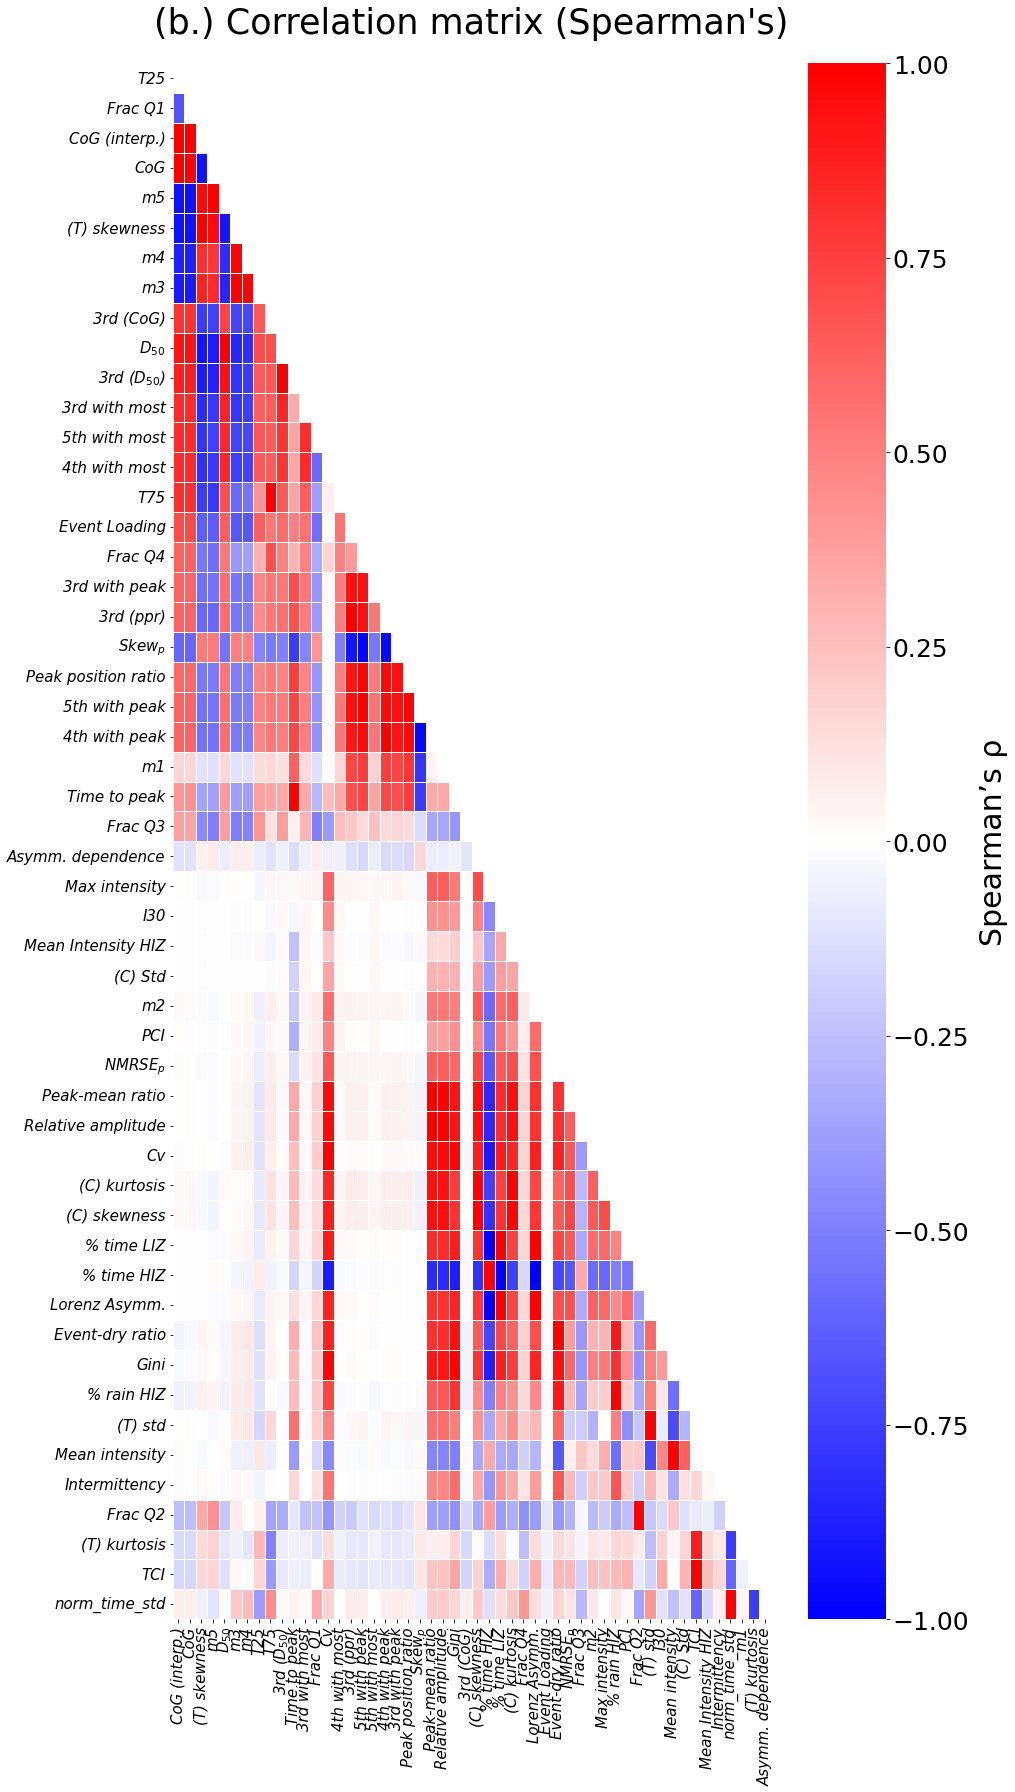

In [118]:
spearman_corr = all_events_5mins.corr(method='spearman')
# Reorder based on absolute total Spearman correlation strength
spearman_strength = spearman_corr.abs().sum().sort_values(ascending=False)
ordered_columns = spearman_strength.index.tolist()
reordered_spearman = spearman_corr.loc[label_list, ordered_columns]

# Plot Spearman heatmap
fig,ax=plt.subplots(figsize=(14,25))
mask = np.triu(np.ones_like(reordered_spearman, dtype=bool))

heatmap = sns.heatmap(
    reordered_spearman,
    mask=mask,
    cmap='bwr',
    annot=False,
    fmt=".2f",
    linewidths=0.8,
    cbar=True,
    cbar_kws={"orientation": "vertical"},
    xticklabels=True,
    yticklabels=True,
    annot_kws={"size": 20},
    vmin=-1, vmax=1,
    ax=ax)

# Change colorbar tick label size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)  # <-- set size here

# Italicise tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontstyle='italic', fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontstyle='italic', fontsize=15)

# Label the colorbar
cbar = heatmap.collections[0].colorbar
cbar.set_label("Spearman’s ρ", fontsize=30, labelpad=10)

plt.title("(b.) Correlation matrix (Spearman's)", fontsize=35,pad=30)
plt.tight_layout()
fig.savefig("../Figures/correlation_matrix.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()